In [1]:
# Install Brian2 in Google Colab
!pip install brian2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 16.7 MB/s eta 0:00:00


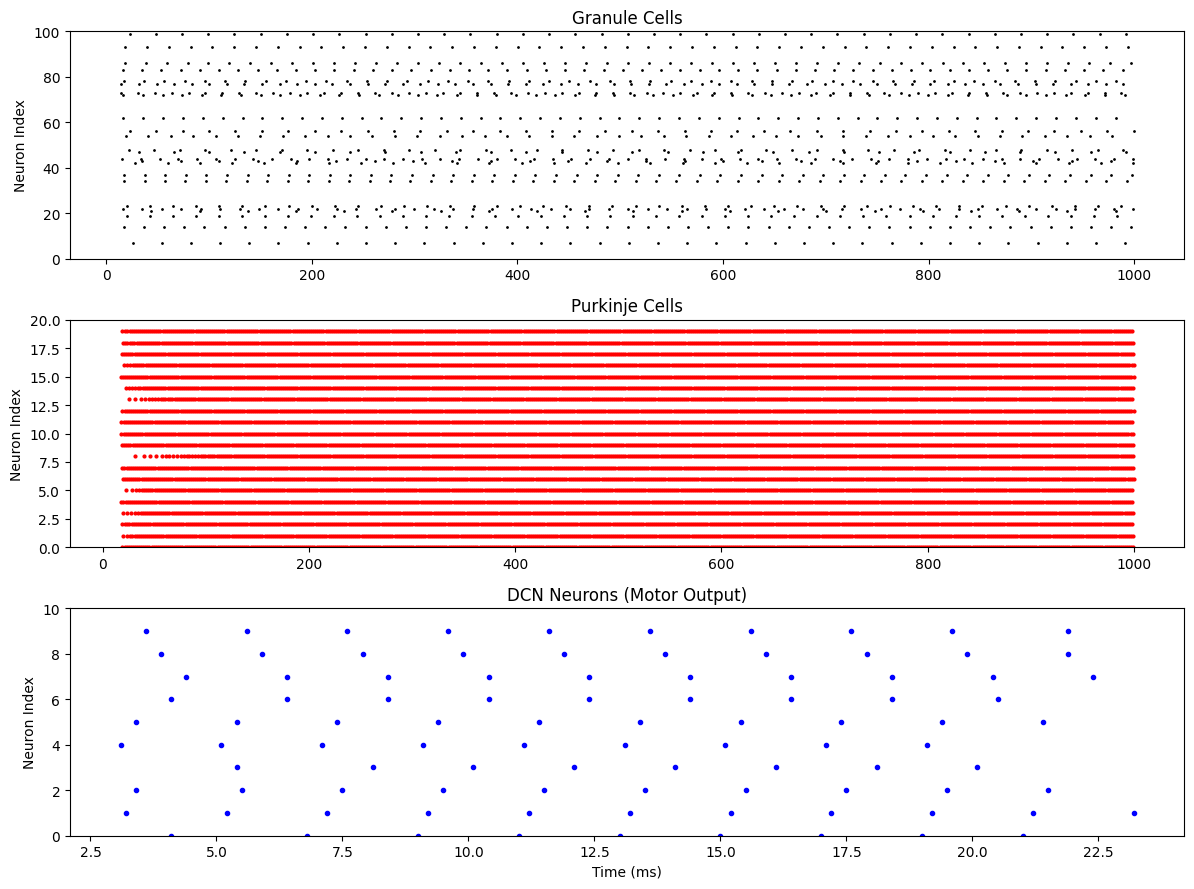

In [4]:
from brian2 import *
import numpy as np

# Simulation parameters
defaultclock.dt = 0.1*ms
duration = 1000*ms

# Neuron parameters
v_rest = -65 * mV
v_reset = -70 * mV
v_thresh_granule_purkinje = -50 * mV  # Threshold for granule/Purkinje
v_thresh_dcn = -55 * mV               # Lower threshold for DCN
tau_m = 10 * ms
R = 20 * Mohm

# Neuron equations
granule_eqs = '''
dv/dt = (v_rest - v + R*I)/tau_m : volt
I : amp
'''

purkinje_eqs = '''
dv/dt = (v_rest - v + R*I)/tau_m : volt
I : amp
'''

dcn_eqs = '''
dv/dt = (v_rest - v + R*I)/tau_m : volt
I : amp
'''

# Create neuron groups
granule_neurons = NeuronGroup(100, granule_eqs,
                             threshold='v > v_thresh_granule_purkinje',
                             reset='v = v_reset',
                             method='exact',
                             refractory=2*ms)

purkinje_neurons = NeuronGroup(20, purkinje_eqs,
                              threshold='v > v_thresh_granule_purkinje',
                              reset='v = v_reset',
                              method='exact',
                              refractory=2*ms)

dcn_neurons = NeuronGroup(10, dcn_eqs,
                         threshold='v > v_thresh_dcn',  # Lower threshold
                         reset='v = v_reset',
                         method='exact',
                         refractory=2*ms)

# Synaptic connections
# Granule -> Purkinje (excitatory)
synapses_granule = Synapses(granule_neurons, purkinje_neurons,
                           on_pre='I += 1.0 * nA')
synapses_granule.connect(p=0.3)

# Purkinje -> DCN (reduced inhibition)
synapses_purkinje = Synapses(purkinje_neurons, dcn_neurons,
                            on_pre='I -= 1.0 * nA')  # Reduced from 1.5nA
synapses_purkinje.connect(p=0.5)

# Sensory input (rectified sine wave + noise)
sensory_input = TimedArray(
    np.abs(np.sin(2 * np.pi * 10 * np.arange(0, duration/ms, defaultclock.dt/ms))) * 4 * nA,
    dt=defaultclock.dt
)
granule_neurons.I = 'sensory_input(t) + 1.0 * nA * rand()'

# Enhanced mossy fiber input to DCN
mossy_to_dcn = PoissonGroup(10, rates=100*Hz)  # Increased from 50Hz
syn_mossy_dcn = Synapses(mossy_to_dcn, dcn_neurons,
                        on_pre='I += 1.5 * nA')  # Increased from 0.8nA
syn_mossy_dcn.connect(p=0.5)

# Initialize voltages
granule_neurons.v = v_rest
purkinje_neurons.v = v_rest
dcn_neurons.v = v_rest

# Monitors
granule_spikes = SpikeMonitor(granule_neurons)
purkinje_spikes = SpikeMonitor(purkinje_neurons)
dcn_spikes = SpikeMonitor(dcn_neurons)

# Run simulation
run(duration)

# Plot results
figure(figsize=(12, 9))

subplot(311)
plot(granule_spikes.t/ms, granule_spikes.i, '.k', markersize=2)
title('Granule Cells')
ylabel('Neuron Index')
ylim([0, 100])

subplot(312)
plot(purkinje_spikes.t/ms, purkinje_spikes.i, '.r', markersize=4)
title('Purkinje Cells')
ylabel('Neuron Index')
ylim([0, 20])

subplot(313)
plot(dcn_spikes.t/ms, dcn_spikes.i, '.b', markersize=6)
title('DCN Neurons (Motor Output)')
xlabel('Time (ms)')
ylabel('Neuron Index')
ylim([0, 10])

tight_layout()
show()